In [2]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl
import matplotlib.pyplot as plt

from scipy.special import legendre

import time

### Next steps
# try to implement with sparse matrices

# Model Parameters

In [3]:
m = 3                              # Angular order
H = 140e3                          # Stratified layer thickness (m)
B = 0.6 * 1.0e-3                   # Radial magnetic field (Tesla)
Np = 0.583                           # dimensionless stratification Np = N/Omega
T = -20.                           # Wave period initial estimate (years)

sectoyear = 365.25 * 24 * 60 * 60
omega0 = 2*np.pi/(T*sectoyear)     # Wave angular frequency initial estimate (rad.s-1)

mu = 4 * np.pi * 1.0e-7            # permeability
sigma = 1.0e6                      # conductivity (S/m)
eta = 1.0 / (mu * sigma);          # diffusivity (m^2/s)
rho = 1.0e4                        # density  (kg/m^3)
R = 3.48e6                         # radius of core (m)
Omega = 0.7292e-4;                 # Earth's rotation rate (s^-1)
N = Np*Omega                       # Layer Brunt-Vaisala frequency (s^-1)
k = np.pi/H                        # vertical wavenumber

ngrid = 200                        # number of grid points in latitude (pole to pole)

##### DERIVED PARAMETERS #####
# evaluate diffusion factor using estimate of omega
chi = 1  +  eta * k**2 * 1j / omega0
M = B**2 * k**4 * R**2 / (rho * mu * N**2 * chi)
Cp = 2*Omega * k**2 * R**2 / N**2
C0 = Cp*omega0

In [14]:
print(chi)

(1-0.04025204081632653j)


In [13]:
print(M)

(0.04859649611772551+0.0019561081452611415j)


# Main code

In [3]:
def secondDerivative(y):
    """Returns a triadiagonal matrix with diagonal elements -2/dy^2, and sup/subdiagonal elements 1/dy^2"""
    n = len(y)
    dy = y[1]-y[0]
    return (1/dy**2)*sps.diags([1, -2, 1], [-1, 0, 1], shape=(n,n)).toarray()

def firstDerivative(y):
    """Returns a differenciation matrix with second order accuracy :
        - triadiagonal matrix with diagonal elements 0, and sup/subdiagonal elements +/- 1/(2*dy)
        - exception for the bounds where a second order one-sided scheme is used
    """
    n = len(y)
    dy = y[1]-y[0]
    D1 = (1/(2*dy))*sps.diags([-1, 0., 1], [-1, 0, 1], shape=(n,n)).toarray()
    D1[0,:3] = np.array([-1.5,2.,-0.5])/dy
    D1[-1,-3:] = np.array([0.5,-2.,1.5])/dy
    
    return D1

def sety(ngrid):
    """Sets the grid (ngrid points between -1 and 1, without the boundaries)"""
    return np.linspace(-1.,1.,ngrid+2)[1:-1] #exclude the -1 and 1 bounds to avoid divisions by 0

def setA(ngrid,m,M):
    """ Sets matrix A of the eigenvalue problem (A - C*In)x = 0"""
    y  = sety(ngrid)
    D2 = secondDerivative(y)
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))

    L2 = -np.diag(m/(y**2))

    return np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])

def modesy(A,C0):
    """Solves the linear eigenvalue problem (A - C*In)x = 0 and returns the corresponding b_theta''(y)"""
    w,v = spl.eig(A)
    i = np.argmin((np.real(w) - C0)**2)

    ## Plot the eigenvalues
    #plt.plot(np.real(w))
    #plt.axhline(0.)
    #plt.ylim(-100,100)
    #plt.title("Eigenvalues")

    # Return the frequency that is closest to the initial estimate
    omega = w[i]/Cp
    return omega,v[:,i]

In [4]:
def responseForcing(y,A,C,m,M,F,Ftheta,Flambda,adaptchi=True):
    ngrid=len(y)
    if adaptchi :
        omega = C/Cp
        chi = 1  +  eta * k**2 * 1j / omega
        M = B**2 * k**4 * R**2 / (rho * mu * N**2 * chi)
    
        ngrid=len(y)
        A=setA(ngrid,m,M)
        A = sps.csc_matrix(A)
    
    D1=firstDerivative(y)
    
    forcingtheta = F*m**2/(M*(1-y**2)) * Ftheta
    forcinglambda = -1j* ( (C*F/M + 2*F/m)*y*Flambda 
                          + m*F/M *(1-y**2)**(-0.5) * np.dot(D1,Flambda*(1-y**2)**(0.5)) 
                         )
    rhs = np.concatenate([np.zeros(ngrid),forcingtheta+forcinglambda])

    return spsl.spsolve(A-C*sps.eye(2*ngrid),rhs)[:ngrid]/(1-y**2)

def plotResponses(ax,ngrid,m,M,F,Ftheta,Flambda,Ftheta_desc,Flambda_desc,adaptchi=True,bounds=[-20,20]):
    y = sety(ngrid)
    A = sps.csc_matrix(setA(ngrid,m,M))
    lbound,rbound=bounds
    Cs = np.linspace(lbound,rbound,1000)
    
    t=time.time()
    responses = np.array([responseForcing(y,A,C,m,M,F,Ftheta,Flambda,adaptchi) for C in Cs])
    print(time.time()-t)
    
    lbl = "F_$\Theta$ = %s, F_$\lambda$ = %s, adaptive chi = %r"%(Ftheta_desc,Flambda_desc,adaptchi)
    
    ax[0].set_title("Real part of (A-CIn)^-1 * F",fontsize=15)
    #ax[0].plot(Cs,spl.norm(np.real(responses),axis=1),label=lbl)
    ax[0].plot(Cs,np.sum(np.real(responses),axis=1),label=lbl)
    
    ax[1].set_title("Imaginary part of (A-CIn)^-1 * F",fontsize=15)
    ax[1].plot(Cs,spl.norm(np.imag(responses),axis=1),label=lbl)
    
    for a in ax:
        a.set_xlabel("C (nondimensional)")
        a.set_ylabel("Amplitude of the wave response")
        a.legend()
        
    w,_ = spl.eig(A.todense())
    for wi in w:
        if np.real(wi)>lbound and np.real(wi)<rbound:
            for a in ax:
                a.axvline(np.real(wi),color='k',linewidth=0.2)

# Solving for the Eigenmodes

C : -4.7
Period : -20.8 years
Quality factor : 69.29


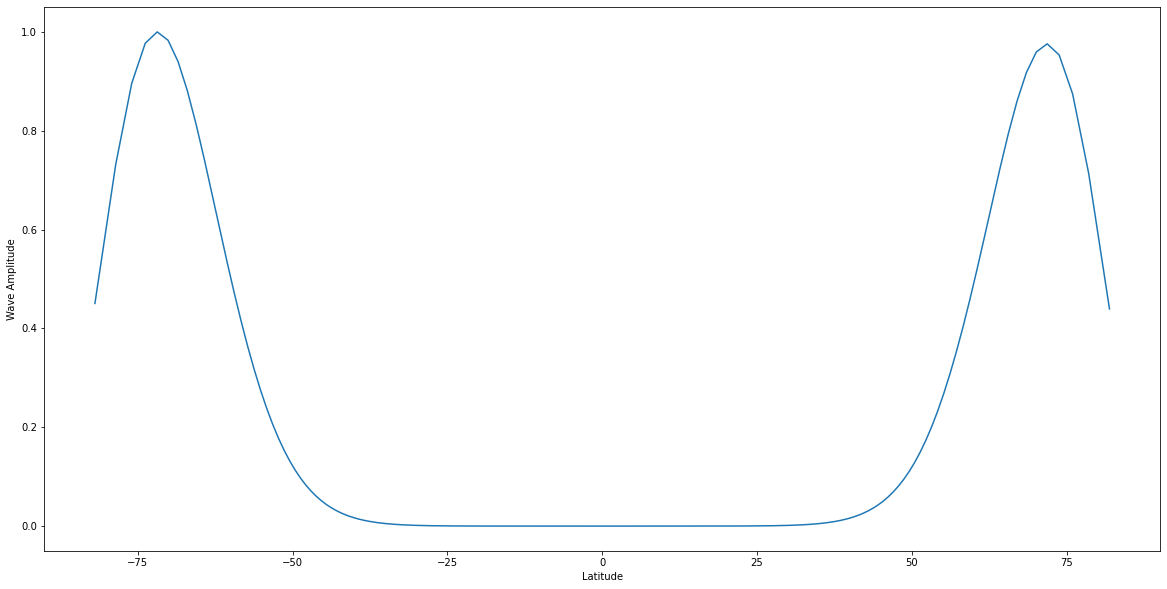

In [5]:
A=setA(ngrid,m,M)
omega,bysec = modesy(A,C0)
y = sety(ngrid)

print("C : %.1f"%(Cp*np.real(omega)))
pd = 2 * np.pi / (sectoyear * np.real(omega)); print("Period : %.1f years"%pd)
q = np.abs(0.5*np.real(omega)/np.imag(omega)); print("Quality factor : %.2f"%q)


lat = np.arcsin(y)*180.0/np.pi

# Code to plot the eigenvector corresponding to the closest eigenvalue
_,ax=plt.subplots(1,1,figsize=(20,10))
by = bysec[:ngrid]/(1-y**2)
amp = np.max(np.abs(np.real(by)));
ax.plot(lat,np.abs(np.real(by))/amp)
ax.set_xlabel("Latitude")
ax.set_ylabel("Wave Amplitude")
plt.show()



## Code to plot the matrix A
#_,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
#p1 = ax1.matshow(np.log10(np.abs(np.real(A))))
#plt.colorbar(p1,ax=ax1);ax1.set_title("log10(real(A))")
#p2 = ax2.matshow(np.log10(np.abs(np.imag(A))))
#plt.colorbar(p2,ax=ax2);ax2.set_title("log10(imag(A))")
#plt.show()

# Solving with forcings $(F_\theta,F_\lambda)$ constant in $y$

7.8036277294158936
1.3530158996582031
7.0579400062561035
1.2141120433807373


Text(0.5, 0.98, 'Constant forcings in y')

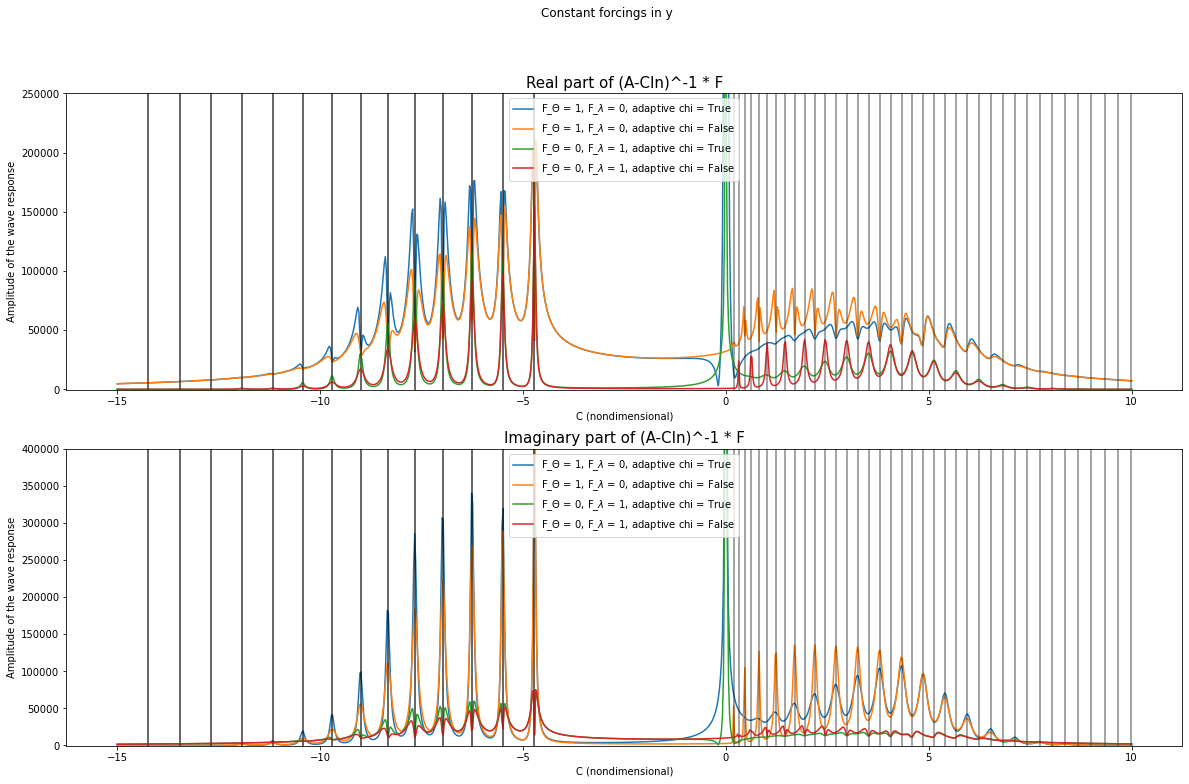

In [9]:
fig,ax=plt.subplots(2,1,figsize=(20,12))
plotResponses(ax,ngrid,m,M,1,1,0,"1","0",adaptchi=True ,bounds=[-15.,10.])
plotResponses(ax,ngrid,m,M,1,1,0,"1","0",adaptchi=False,bounds=[-15.,10.])
plotResponses(ax,ngrid,m,M,1,0,1,"0","1",adaptchi=True ,bounds=[-15.,10.])
plotResponses(ax,ngrid,m,M,1,0,1,"0","1",adaptchi=False,bounds=[-15.,10.])
ax[0].set_ylim(-5e2,2.5e5);ax[1].set_ylim(-5e2,4e5)
fig.suptitle("Constant forcings in y")

7.682378053665161
1.2018239498138428


Text(0.5, 0.98, 'Constant forcings in y')

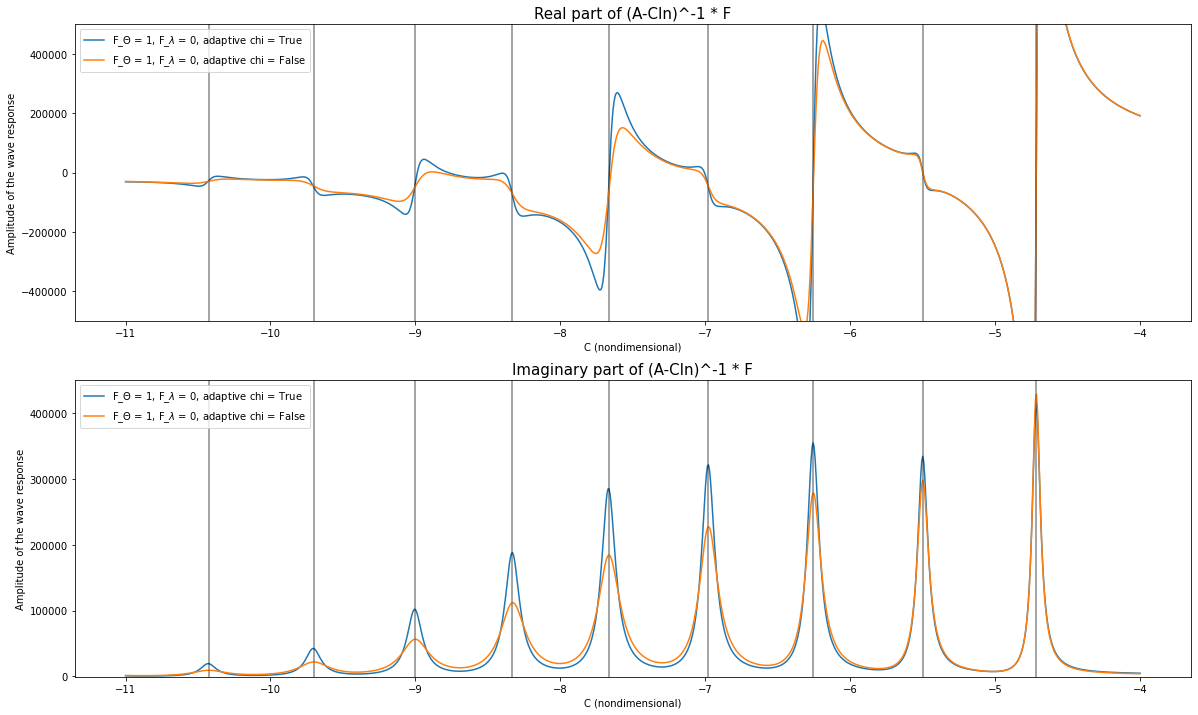

In [20]:
_,ax=plt.subplots(2,1,figsize=(20,12))
plotResponses(ax,ngrid,m,M,1,1,0,"1","0",adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,1,0,"1","0",adaptchi=False,bounds=[-11.,-4.])
ax[0].set_ylim(-5e5,5e5);ax[1].set_ylim(-5e2,4.5e5)
fig.suptitle("Constant forcings in y")

# Solving with spherical harmonic forcings $(F_\theta,F_\lambda)$

8.90744400024414
7.103278875350952
6.732355117797852
7.96936297416687
9.08408784866333


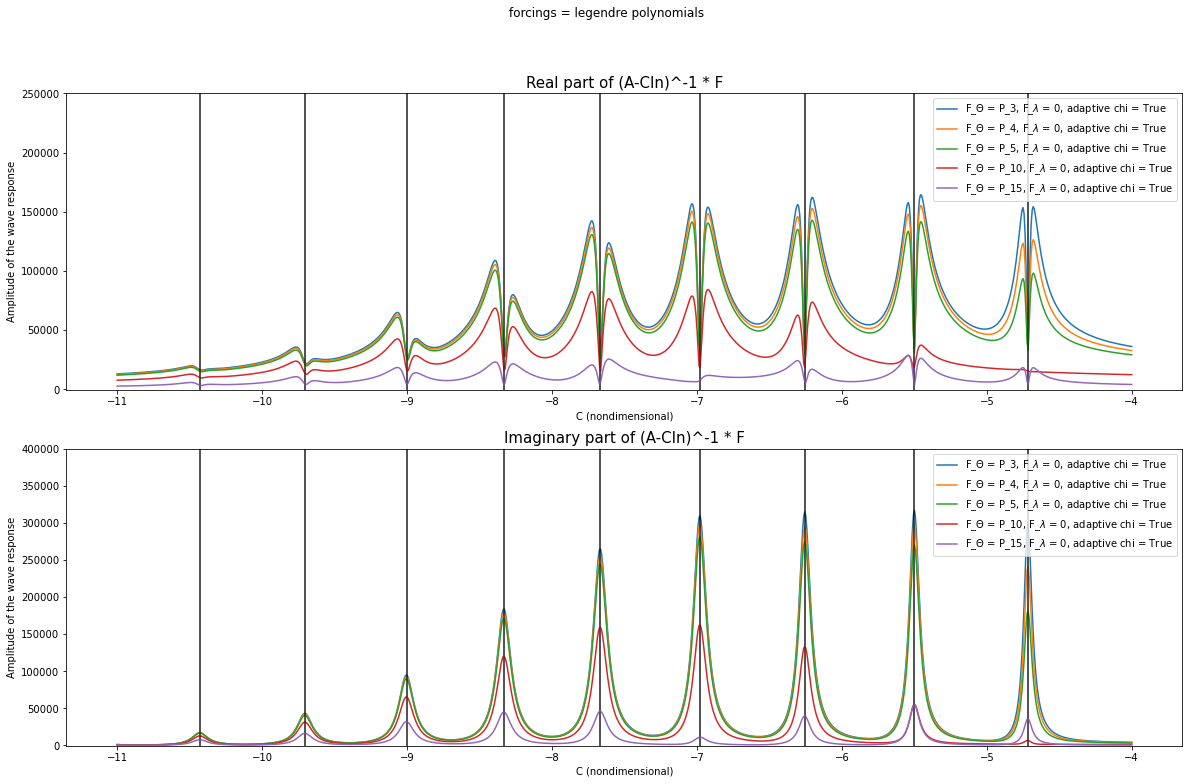

In [14]:
fig,ax=plt.subplots(2,1,figsize=(20,12))
plotResponses(ax,ngrid,m,M,1,legendre(3)(sety(ngrid)) ,0,"P_3" ,"0",adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,legendre(4)(sety(ngrid)) ,0,"P_4" ,"0",adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,legendre(5)(sety(ngrid)) ,0,"P_5" ,"0",adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,legendre(10)(sety(ngrid)),0,"P_10","0",adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,legendre(15)(sety(ngrid)),0,"P_15","0",adaptchi=True ,bounds=[-11.,-4.])
ax[0].set_ylim(-5e2,2.5e5);ax[1].set_ylim(-5e2,4e5)
fig.suptitle("forcings = legendre polynomials");None

6.763130187988281
6.206027030944824
6.581992149353027
6.438643932342529
7.246063947677612


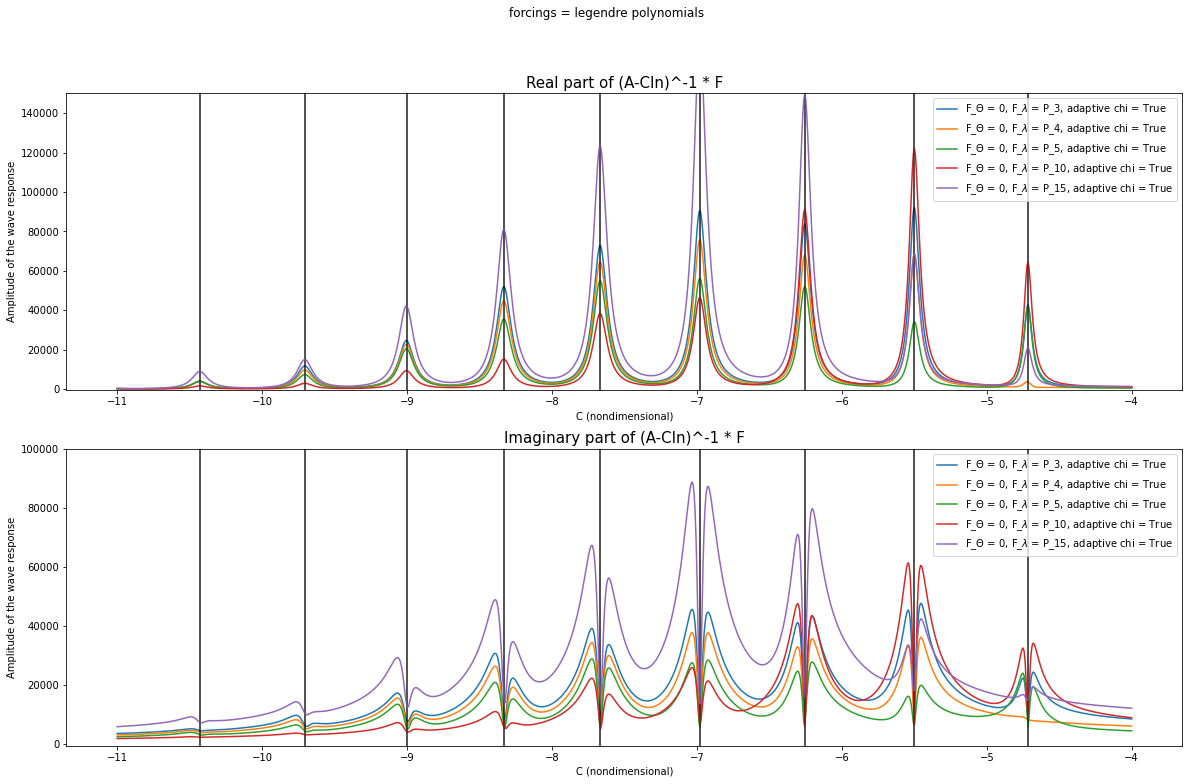

In [15]:
fig,ax=plt.subplots(2,1,figsize=(20,12))
plotResponses(ax,ngrid,m,M,1,0,legendre(3)(sety(ngrid)) ,"0","P_3" ,adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,0,legendre(4)(sety(ngrid)) ,"0","P_4" ,adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,0,legendre(5)(sety(ngrid)) ,"0","P_5" ,adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,0,legendre(10)(sety(ngrid)),"0","P_10",adaptchi=True ,bounds=[-11.,-4.])
plotResponses(ax,ngrid,m,M,1,0,legendre(15)(sety(ngrid)),"0","P_15",adaptchi=True ,bounds=[-11.,-4.])
ax[0].set_ylim(-5e2,2e5);ax[1].set_ylim(-5e2,1e5)
fig.suptitle("forcings = legendre polynomials");None